# Find MSLP analogues of ERA5 event 
- search for analogues in ERA5 dataset
- search for analogues in CRCM5 Large Ensemble

### Packages and Directories

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import time
import dask
from dask.distributed import LocalCluster, Client, progress
import matplotlib.pyplot as plt
import os
import calendar
from collections import defaultdict
from scipy.interpolate import griddata

# my function files
import sys
sys.path.append('/home/portal/script/python/precip_Cristina/')
import functions_visualise_PrMax as fvp
import functions_analogues_LUCAFAMOSS as fan

In [2]:
CERRA_dir = '/work_big/users/clima/portal/CERRA-Land/'
ERA5_dir = '/work_big/users/clima/portal/ERA5/'
CRCM5_dir = '/work_big/users/clima/portal/CRCM5-LE/'
fig_dir = '/home/portal/figures/case-studies_byNode/'

### Identify date of ERA5 event

In [3]:
# Event selection
lselect = 'alert-regions'  # 'Italy' or 'wide-region' or 'alert-regions'
no_node = 1
no_event = 1
# Upload the data
if lselect == 'wide-region':
    df_events = pd.read_excel(CERRA_dir+'events_on_wide_regions.xlsx', sheet_name=no_node-1)
elif lselect == 'alert-regions':
    df_events = pd.read_excel(CERRA_dir+'events_cum_on_above99_alert_regions.xlsx', sheet_name=no_node-1)
elif lselect == 'Italy':
    df_events = pd.read_excel(CERRA_dir+'events_on_Italy.xlsx', sheet_name=no_node-1)
time_event = df_events['Time'].iloc[no_event-1] + pd.Timedelta('12h')
doy_event =  time_event.timetuple().tm_yday
# Define lon-lat box of event
box_event = fvp.box_event_PrMax_alertregions(no_node,no_event)

print('Event time:', time_event)
print('Event DOY:', doy_event)
print('Event box:', box_event)

Event time: 2018-10-29 18:00:00
Event DOY: 302
Event box: [-5, 20, 31, 50]


In [4]:
# Define the months for analogue selection
month_event = time_event.month
months_sel = [month_event-1, month_event, month_event+1]
# Get the month names
month_names = [calendar.month_abbr[month] for month in months_sel]
# Extract the initials
str_months = ''.join([name[0] for name in month_names])

### Upload ERA5 anomaly map of event

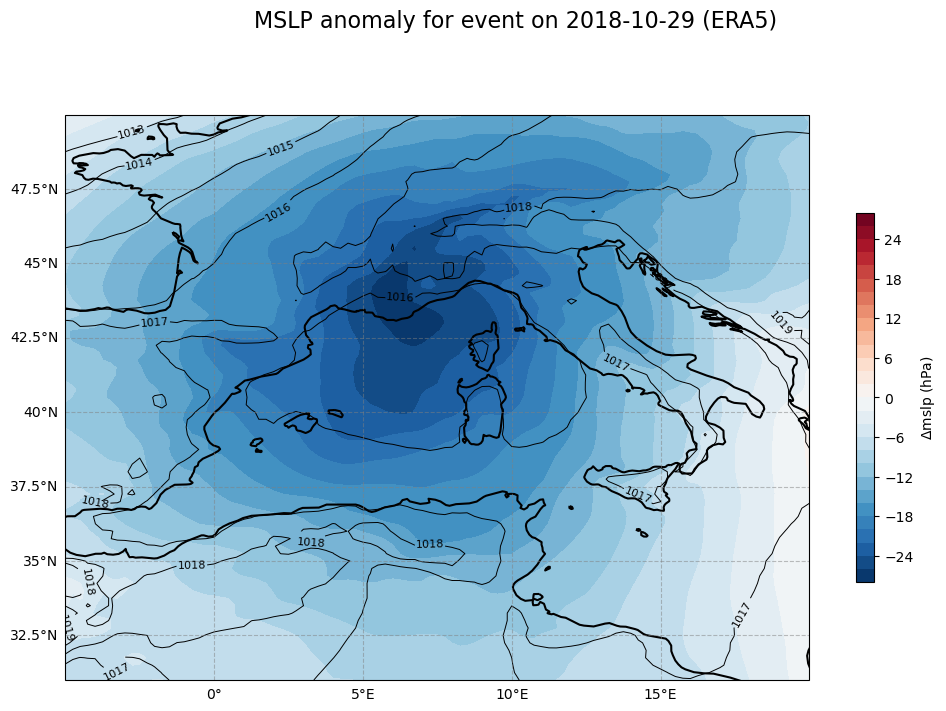

In [5]:
# Upload event mslp data
dmslp_event = fvp.load_ERA5_data('mslp', 'daily', time_event, box_event, l_anom=True)
mslp_clim = fvp.load_ERA5_clim('mslp', doy_event, box_event, l_smoothing=True)

# Plot event
fig, ax = fvp.plot_anom_event("mslp", dmslp_event.longitude, dmslp_event.latitude, dmslp_event.values, mslp_clim)
fig.suptitle("MSLP anomaly for event on "+str(time_event)[:10]+" (ERA5)", fontsize=16)
fig.show()
fig.savefig(fig_dir+'mslp_node'+str(no_node)+'_extreme'+str(no_event)+'-alertregions_box-analogues.png')

#### Regrid ERA5 event anomaly to 0.5 resolution

In [6]:
def regrid_to_half_degree(field_event, box_event):
    """
    Regrid a 2D xarray.DataArray to a 0.5° x 0.5° regular lat/lon grid using linear interpolation.

    Parameters
    ----------
    dmslp_event : xr.DataArray
        Input data with dimensions ('latitude', 'longitude') or ('lat', 'lon').
    box_event : list or tuple
        Bounding box [lon_min, lon_max, lat_min, lat_max] defining the new grid extent.

    Returns
    -------
    xr.DataArray
        Regridded data on 0.5° resolution grid.
    """
    # Extract old values
    values = field_event.values.flatten()

    # Handle coordinate naming ('lat' vs 'latitude', 'lon' vs 'longitude')
    lat_name = 'lat' if 'lat' in field_event.dims else 'latitude'
    lon_name = 'lon' if 'lon' in field_event.dims else 'longitude'

    # Old grid coordinates
    lon_grid, lat_grid = np.meshgrid(field_event[lon_name].values,
                                     field_event[lat_name].values)
    coordinates = np.array([lon_grid.ravel(), lat_grid.ravel()]).T

    # New grid: 0.5-degree resolution within box_event
    new_lat = np.arange(box_event[2], box_event[3] + 0.5, 0.5)
    new_lon = np.arange(box_event[0], box_event[1] + 0.5, 0.5)
    new_lon_grid, new_lat_grid = np.meshgrid(new_lon, new_lat)
    new_coordinates = np.array([new_lon_grid.ravel(), new_lat_grid.ravel()]).T

    # Interpolate using linear method
    interp_values = griddata(coordinates, values, new_coordinates, method='linear')
    interp_values = interp_values.reshape(new_lat.shape[0], new_lon.shape[0])

    return interp_values, new_lat, new_lon

In [ ]:
import xesmf as xe

def regrid_with_xesmf(field_event, box_event, resolution=0.5):
    # Determine input lat/lon names
    lat_name = 'lat' if 'lat' in field_event.dims else 'latitude'
    lon_name = 'lon' if 'lon' in field_event.dims else 'longitude'

    # Define the new grid
    new_lat = np.arange(box_event[2], box_event[3] + resolution, resolution)
    new_lon = np.arange(box_event[0], box_event[1] + resolution, resolution)
    target_grid = xr.Dataset({
        'lat': (['lat'], new_lat),
        'lon': (['lon'], new_lon),
    })

    # Prepare the regridder
    regridder = xe.Regridder(field_event, target_grid, method='bilinear', periodic=False, reuse_weights=False)

    # Apply regridding (automatically handles time if present)
    return regridder

In [7]:
# Regrid the event mslp data to 0.5° resolution 
# This will match the LE data resolution
dmslp_event_05, lat_box_05, lon_box_05 = regrid_to_half_degree(dmslp_event, box_event)
# Construct regridded DataArray
dmslp_event_regridded = xr.DataArray(
    dmslp_event_05,
    dims=["lat", "lon"],
    coords={"lat": lat_box_05, "lon": lon_box_05},
    name=dmslp_event.name if dmslp_event.name else "regridded"
)

In [8]:
def timefilter_analogues(analogue_indices, logdist, time_sel, time_spacing):
    """
    Filters analogue dates based on a precomputed logdist,
    ensuring analogues are at least ±7 days apart from each other.

    Parameters:
        analogue_indices (np.ndarray): Indices for valid analogues (refers to time_sel) (n_analogues)
        logdist (np.ndarray): Log-transformed distance array (n_times)
        time_sel (xr.DataArray): Range of times in field selection (n_times)
        time_spacing (int): Minimum spacing in days between selected analogues

    Returns:
        selected_indices (np.ndarray): Indices of selected analogue times in time_sel
    """

    # Select best analogues with ≥7-day spacing among themselves
    sorted_indices = analogue_indices[np.argsort(-logdist[analogue_indices])]  # sort by descending logdist (best analogue first)

    selected_indices = []
    selected_times = [] # store already accepted analogue times (for spacing check)

    for idx in sorted_indices:
        this_time = time_sel[idx]
        if all(abs((this_time - t).days) >= time_spacing for t in selected_times):
            selected_indices.append(idx)
            selected_times.append(this_time)
    
    return np.array(selected_indices,dtype=int)

## Find analogues in ERA5

In [9]:
# Selection of data for analogues
# Variable
varname = 'mslp'
# Time
year_range = [2004, 2023]
years_sel = np.arange(year_range[0], year_range[1]+1)
# Quantile
qtl = 0.99

In [10]:
# Load and preprocess mslp data for analogues

# Define the file pattern for loading mslp data
file_pattern = ERA5_dir + varname +"/ERA5_"+varname+"_NH_daily_*_anom.nc"
dmslp_tmp = xr.open_mfdataset(file_pattern, combine='by_coords', parallel=True)['msl'] * 0.01
dmslp_tmp = dmslp_tmp.sel(time=dmslp_tmp.time.dt.month.isin(months_sel))
dmslp_tmp = dmslp_tmp.sel(time=dmslp_tmp.time.dt.year.isin(years_sel))

# Define and select lon lat masks (specific of each event)
lon_mask, lat_mask = fvp.lonlat_mask(dmslp_tmp.longitude.values, dmslp_tmp.latitude.values, box_event)
mask = lat_mask[:, np.newaxis] & lon_mask
mask_xr = xr.DataArray(
    mask,
    dims=["latitude", "longitude"],
    coords={"latitude": dmslp_tmp.latitude, "longitude": dmslp_tmp.longitude},
)

# Apply mask to the dataset
dmslp_sel = dmslp_tmp.where(mask_xr, drop=True)

In [11]:
# Compute euclidean distance from the event to the selected mslp data
dist = fan.function_distance(dmslp_event,dmslp_sel, nan_version=False)

#### Analogue selection
1. Exclude analogues within ±7 days of their associated event

2. For each event, select analogues with >=7-day spacing (keeping best)

3. Select and average selected analogues

In [ ]:
# Compute log-transformed distance
logdist = np.log(1 / dist)
# Threshold at given quantile
thresh = np.percentile(logdist, qtl * 100, axis=0)
mask_analogues = logdist >= thresh

# Event time, all times and required time spacing
all_times = dmslp_sel.time.values
event_time = dmslp_event.time.values
analogue_spacing = 7 # days

# Exclude analogue times within ±7 days of their associated event
time_diff = np.abs((all_times - event_time).astype('timedelta64[D]').astype(int))
mask_analogues &= np.array(time_diff) >= analogue_spacing  # update mask to exclude times too close to the event
indices_analogues = np.where(mask_analogues)[0]  # indices of all valid analogue times

# Filter analogues based on the mask and logdist, ensuring they are spaced correctly (analogue_spacing days apart)
indices_filtered_analogues = timefilter_analogues(indices_analogues, logdist, all_times, analogue_spacing)

# Select and average
dmslp_analogues = dmslp_sel.isel(time=indices_filtered_analogues)
dmslp_analogues_mean = dmslp_analogues.mean(dim='time')
dmslp_analogues_mean_values = dmslp_analogues_mean.values

/tmp/ipykernel_2970802/3060685972.py:2: RuntimeWarning: divide by zero encountered in divide
  logdist = np.log(1 / dist)


In [1]:
dmslp_analogues_regridded = regrid_with_xesmf(dmslp_analogues, box_event, resolution=0.5)
print("Done with regridding")

NameError: name 'regrid_with_xesmf' is not defined

In [ ]:
print(len(indices_filtered_analogues), "analogues selected.")
# print("Time analogue events:", all_times[indices_filtered_analogues])

13 analogues selected.


#### Compute mean on ERA5 analogues

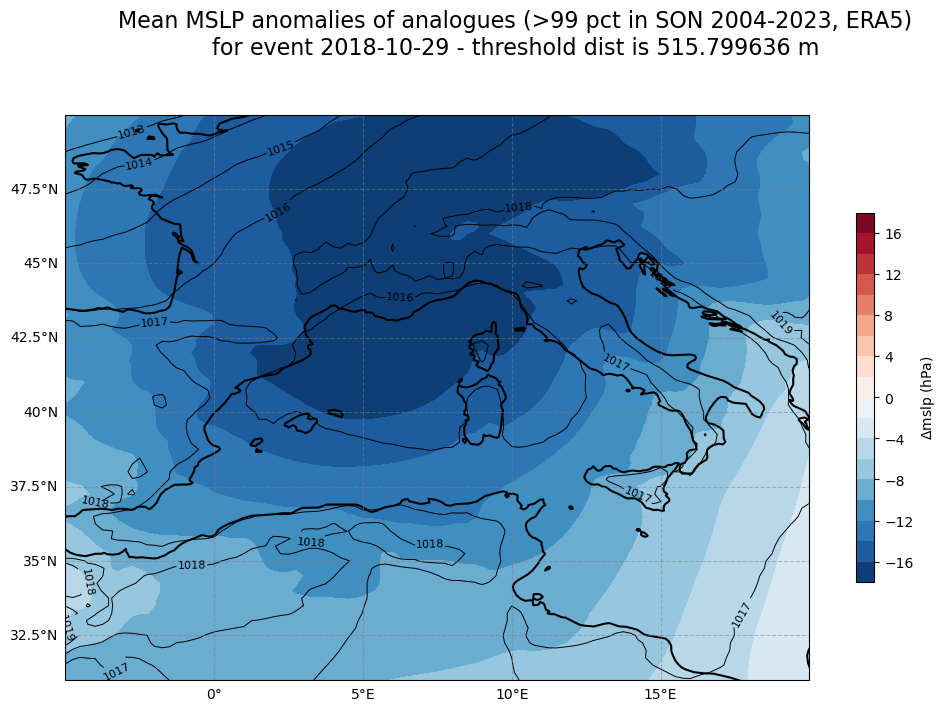

In [ ]:
# Plot analogue mean
fig, ax = fvp.plot_anom_event("mslp", dmslp_analogues_mean.longitude, dmslp_analogues_mean.latitude, dmslp_analogues_mean_values, mslp_clim) #

fig.suptitle("Mean MSLP anomalies of analogues (>"+str(int(qtl*100))+" pct in "+str_months+' '+str(year_range[0])+'-'+str(year_range[1])+", ERA5)\nfor event "+str(time_event)[:10]+\
             " - threshold dist is "+str(1/np.exp(thresh))[:10]+" m", fontsize=16)
fig.show()
fig.savefig(fig_dir+'analogues-mslp_node'+str(no_node)+'_extreme'+str(no_event)+'-alertregions_mean_'+str(int(qtl*100))+'pct_'+str_months+'_'+str(year_range[0])+'-'+str(year_range[1])+'_ERA5.png')

## Find analogues in CRCM5

In [ ]:
# Parameter selection
varname = 'psl'
year_range = [2004, 2023]
month_event = time_event.month
months_sel = [month_event-1, month_event, month_event+1]
years_sel = np.arange(year_range[0], year_range[1]+1)
no_membs = 2  # Number of members to select
# Quantile
qtl_LE = 0.99

#### File paths per member

In [ ]:
# List of members
list_membs = [name for name in os.listdir(CRCM5_dir + varname) if os.path.isdir(os.path.join(CRCM5_dir + varname, name))]
list_membs = sorted(list_membs)[:no_membs]  # Select the first 'no_membs' members
# List file paths
dirs_files = [CRCM5_dir + varname + '/' + membs + '/'+ str(year) + '/res05/' for year in years_sel for membs in list_membs]
prefix_files = varname + '-anom'

# Loop through each item in the main folder
paths_files = []
for dir in dirs_files:
    # Loop through files in the subdirectory
    if len(os.listdir(dir)) != 24:
        print('Warning: missing files in', dir)
    for file in os.listdir(dir):
        file_path = os.path.join(dir, file)  # Full file path
        if os.path.isfile(file_path):  # Check if it is a file
            paths_files.append(file_path) if file.startswith(prefix_files) else None

# Create a dictionary: member -> list of files
memb_files = fvp.create_member_file_dict(paths_files, list_membs)
# print(len(memb_files['kba']))

In [ ]:
# Same for clim files
# List clim file paths
dirs_files_clim = [CRCM5_dir + varname + '/' + membs + '/clim/' for membs in list_membs]
suffix_files_clim = 'clim'+str(year_range[0])+'-'+str(year_range[1])+'_sm31d_05res.nc'

# Loop through each item in the main folder
paths_files_clim = []
for dir in dirs_files_clim:
    # Loop through files in the subdirectory
    for file in os.listdir(dir):
        file_path = os.path.join(dir, file)  # Full file path
        if os.path.isfile(file_path):  # Check if it is a file
            paths_files_clim.append(file_path) if file.endswith(suffix_files_clim) else None

# Create a dictionary: member -> list of files
memb_files_clim = fvp.create_member_file_dict(paths_files_clim, list_membs)

# Sort paths for each member (by filename or full path)
for memb in memb_files_clim:
    memb_files_clim[memb].sort()

#### Open CRCM5 data

In [ ]:
# Make list of datasets and add 'member' coordinate
list_ds = fvp.open_member_datasets(memb_files, combine='by_coords', expand_member_dim=True)
list_ds_clim = fvp.open_member_datasets(memb_files_clim, combine='by_coords', expand_member_dim=True)
# ??? Can.t open in parallel (gives error) 

# Concatenate and scale
dmslp_tmp_LE = xr.concat(list_ds, dim='member')[varname] * 0.01
dmslp_tmp_clim_LE = xr.concat(list_ds_clim, dim='member')[varname] * 0.01

Opening files for member: kba


Opening files for member: kbb
Opening files for member: kba
Opening files for member: kbb


In [ ]:
# Select the time range for the event
dmslp_tmp_LE = dmslp_tmp_LE.sel(time=dmslp_tmp_LE.time.dt.month.isin(months_sel))
dmslp_tmp_LE = dmslp_tmp_LE.sel(time=dmslp_tmp_LE.time.dt.year.isin(years_sel))
mslp_tmp_clim_LE = dmslp_tmp_clim_LE.sel(time=dmslp_tmp_clim_LE.time.dt.month.isin(months_sel))

# Select lon lat mask for the event
lon_mask_LE, lat_mask_LE = fvp.lonlat_mask(dmslp_tmp_LE.lon.values, dmslp_tmp_LE.lat.values, box_event)
mask_LE = lat_mask_LE[:, np.newaxis] & lon_mask_LE
mask_xr_LE = xr.DataArray(
    mask_LE,
    dims=["lat", "lon"],
    coords={"lat": dmslp_tmp_LE.lat.values, "lon": dmslp_tmp_LE.lon.values},
)
dmslp_sel_LE = dmslp_tmp_LE.where(mask_xr_LE, drop=True)
mslp_sel_clim_LE = dmslp_tmp_clim_LE.where(mask_xr_LE, drop=True)

mask_notnans = (~dmslp_sel_LE.isnull().any(dim=('member','time')))

#### Compute distances from ERA5 event and select analogues

In [ ]:
dist_LE = []  # Initialize an empty list to store distances for each member
for ii, memb in enumerate(list_membs):
    print('Computing distance for member:', memb)
    # Compute euclidean distance from the event to the selected mslp data for each member
    dist_memb = fan.function_distance(dmslp_event_regridded, dmslp_sel_LE.sel(member=memb), nan_version=True)
    dist_LE.append(dist_memb)

# # Convert to a 2D NumPy array: shape = [n_memb, n_times]
# dist_LE = np.stack(dist_LE, axis=0)

Computing distance for member: kba
Computing distance for member: kbb


In [ ]:
list_dmslp_analogues_LE = []  # Initialize an empty list to store analogue data for each member
dmslp_analogues_membmean_LE = []  # Initialize an empty list to store mean analogue data for each member
# Time values and analogue spacing
all_times_LE = dmslp_sel_LE.time.values
analogue_spacing = 7 # days
thresh_LE = []

# Find analogue indices for each member
indices_filtered_analogues_LE = []  # Initialize an empty list to store filtered indices for each member
for ii, memb in enumerate(list_membs):
    print('Processing member:', memb)
    # Compute log-transformed distance
    logdist_memb = np.log(1 / dist_LE[ii])
    # Threshold at given quantile
    thresh_memb = np.percentile(logdist_memb, qtl_LE * 100, axis=0)
    thresh_LE.append(thresh_memb)
    mask_analogues_memb = (logdist_memb >= thresh_memb)
    indices_analogues_memb = np.where(mask_analogues_memb)[0]  # indices of all valid analogue times

    # Filter analogues based on the mask and logdist, ensuring they are spaced correctly (analogue_spacing days apart)
    indices_filtered_analogues_memb = timefilter_analogues(indices_analogues_memb, logdist_memb, all_times_LE, analogue_spacing)
    indices_filtered_analogues_LE.append(indices_filtered_analogues_memb)
    # Select and average for each member
    list_dmslp_analogues_LE.append(dmslp_sel_LE.isel(member=ii, time=indices_filtered_analogues_memb))
    dmslp_analogues_membmean_LE.append(list_dmslp_analogues_LE[-1].mean(dim='time'))
dmslp_analogues_membmean_LE = xr.concat(dmslp_analogues_membmean_LE, dim='member')
thresh_LE = np.array(thresh_LE)

Processing member: kba
Processing member: kbb


In [ ]:
# # Apply mask to find matching analogues
# analogues_indices = np.where(mask_analogues_LE)[0]
# analogues_coords = dmslp_sel_LE_stacked.member_time[analogues_indices]
clim_analogues_LE = []  # Initialize an empty list to store analogue clim per member
doy_clim = mslp_sel_clim_LE['time'].dt.dayofyear

for ii, memb in enumerate(list_membs):
    time_values = list_dmslp_analogues_LE[ii].time
    doy_values = time_values.dt.dayofyear.values

    i_loop = 0
    for doy in doy_values:
        # Select for specific member and matching DOY
        mask_time = doy_clim == doy
        if i_loop == 0:
            clim_memb = mslp_sel_clim_LE.sel(member=memb).sel(time=mask_time).squeeze('time')
        else:
            clim_memb = clim_memb + mslp_sel_clim_LE.sel(member=memb).sel(time=mask_time).squeeze('time')
        i_loop += 1
    clim_analogues_LE.append(clim_memb/i_loop)
clim_analogues_LE = xr.concat(clim_analogues_LE, dim='member')


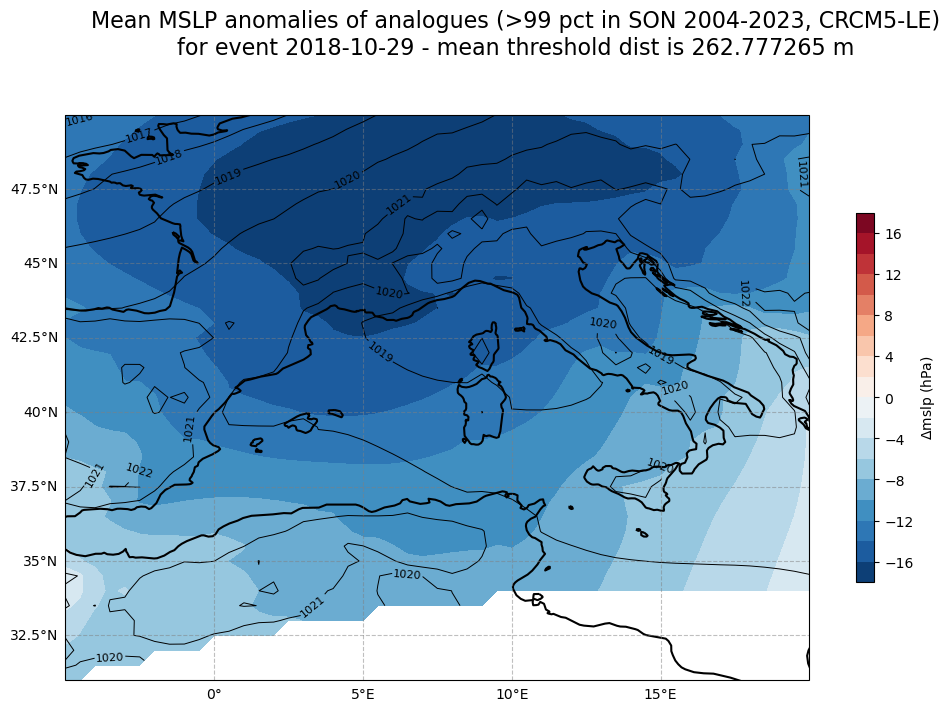

In [ ]:
# Plot LE analogue mean
fig, ax = fvp.plot_anom_event('mslp', dmslp_analogues_membmean_LE.lon, dmslp_analogues_membmean_LE.lat, dmslp_analogues_membmean_LE.mean(dim='member'), clim_analogues_LE.mean(dim='member').values) #

fig.suptitle("Mean MSLP anomalies of analogues (>"+str(int(qtl_LE*100))+" pct in "+str_months+' '+str(year_range[0])+'-'+str(year_range[1])+", CRCM5-LE)\nfor event "+str(time_event)[:10]+\
             " - mean threshold dist is "+str(1/np.exp(thresh_LE.mean()))[:10]+' m', fontsize=16)
fig.show()
fig.savefig(fig_dir+'analogues-mslp_node'+str(no_node)+'_extreme'+str(no_event)+'-alertregions_mean_'+str(int(qtl_LE*100))+'pct_'+str_months+'_'+str(year_range[0])+'-'+str(year_range[1])+'_CRCM5-LE.png')

### Compare percentile threshold ERA5 - CRCM5-LE

In [ ]:
import xesmf as xe

def regrid_with_xesmf(field_event, box_event, resolution=0.5):
    # Determine input lat/lon names
    lat_name = 'lat' if 'lat' in field_event.dims else 'latitude'
    lon_name = 'lon' if 'lon' in field_event.dims else 'longitude'

    # Define the new grid
    new_lat = np.arange(box_event[2], box_event[3] + resolution, resolution)
    new_lon = np.arange(box_event[0], box_event[1] + resolution, resolution)
    target_grid = xr.Dataset({
        'lat': (['lat'], new_lat),
        'lon': (['lon'], new_lon),
    })

    # Prepare the regridder
    regridder = xe.Regridder(field_event, target_grid, method='bilinear', periodic=False, reuse_weights=False)

    # Apply regridding (automatically handles time if present)
    return regridder(field_event)

In [ ]:
# Regrid and mask ERA5 analogues (to match LE data)
# for ii in range(len(dmslp_analogues.time)):

dmslp_analogues_regridded = regrid_with_xesmf(dmslp_analogues, box_event, resolution=0.5)
print("Done with regridding")

Done with regridding


KeyboardInterrupt: 

In [ ]:
dist_analogues_regridded = fan.function_distance(dmslp_event_regridded, dmslp_analogues_regridded*mask_notnans, nan_version=True)
# mean_dist_analogues_regridded = np.mean(dist_analogues_regridded)

KeyboardInterrupt: 

In [ ]:
print("Mean distance of regridded analogues:", np.mean(dist_analogues_regridded))